In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, LSTM
from keras.applications.densenet import DenseNet121, preprocess_input
from keras import Input
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree, copyfile
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score, f1_score
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re
from tensorflow.keras.utils import Sequence

# Project variables

In [2]:
m_name = "combo model v3"
p_dir = os.path.join("../combo models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [41]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [5]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [6]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [7]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [8]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)

In [9]:
combo.shape

(19311, 17)

# Define categories

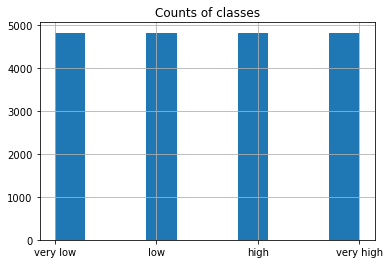

In [10]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [11]:
cat_lbl = ["very low", "very high"]
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

5793 1931 1932


# Build the model

In [12]:
def create_img_model():
    
    inp = Input(shape=(180, 320, 3))
    
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="sigmoid")(x)
    
    model = Model(base_model.input, out)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [13]:
pt_model = "roberta-base"

In [14]:
def create_nlp_model():
    
    # config = RobertaConfig(dropout=0.2, attention_dropout=0.2)
    # config.output_hidden_states=False
    transformer_model = TFRobertaModel.from_pretrained(pt_model)

    in_ids = Input(shape=(100,), name="input_token", dtype="int32")
    in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

    emb = transformer_model(in_ids, attention_mask=in_masks)[0]
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
    x = GlobalMaxPool1D()(x)
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[in_ids, in_masks], outputs=x)
        
    return model

In [15]:
def create_model():
    
    # Load image model with weights and remove last layer
    m_name = "densenet_2_classes_bce_fmt2"
    img_model = create_img_model()
    img_model.load_weights("../img models/{a}/{a}".format(a=m_name))
    for layer in img_model.layers:
        layer.trainable = False
    
    # Load nlp model with weights and remove last layer
    m_name = "roberta_2_classes"
    nlp_model = create_nlp_model()
    nlp_model.load_weights("../nlp models/{a}/{a}".format(a=m_name))
    for layer in nlp_model.layers:
        layer.trainable = False
    
    m1 = img_model.layers[-4].output
    m1 = Dense(50, activation="relu")(m1)
    m1 = BatchNormalization()(m1)
    m2 = nlp_model.layers[-3].output
    # m2 = BatchNormalization()(m2)
    x = Concatenate()([m1, m2])
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    # x = Dense(100, activation="relu")(x)
    # x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[img_model.input, nlp_model.input[0], nlp_model.input[1]], outputs=x)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=["accuracy"])
    
    return model    

In [16]:
model = create_model()

2021-12-14 19:11:23.291738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 19:11:23.318891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 19:11:23.319502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 19:11:23.320659: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
# model.summary()

# Text preprocessing and tokenization

In [18]:
def preprocessing_sentence(txt: str, remove_stopwords: bool=False) -> str:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(txt, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(txt)
        txt = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            txt = " ".join([w for w in txt.split() if w not in stw])
        
        return txt
    
    txt = cleanse_row(txt, field, stw, remove_stopwords)
    return txt

In [19]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
remove_stopwords = False

def preprocess_sentences(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing_sentence(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [21]:
tok = RobertaTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [22]:
def tokenize(sentence, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    
    inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                   return_token_type_ids=True, truncation=True)
    input_ids.append(inputs["input_ids"])
    input_masks.append(inputs["attention_mask"])
    input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

# Prepare DataGenerators

In [23]:
class TkDataGenerator(Sequence):
    def __init__(self, df, img_col, txt_col, y_col, img_dir, img_pp_func, txt_pp_func, tok_func, tokenizer, lb, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.img_pp_func = img_pp_func
        self.txt_pp_func = txt_pp_func
        self.tok_func = tok_func
        self.tokenizer = tokenizer
        self.lb = lb
        self.img_col = img_col
        self.txt_col = txt_col
        self.y_col = y_col
        self.lb = lb
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        x1, x2, x3, y = self.__get_data(batch)
        return (x1, x2, x3), y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = np.empty((self.batch_size, *(180, 320, 3)), dtype="float32")
        x2 = np.empty((self.batch_size, 100), dtype="int32")
        x3 = np.empty((self.batch_size, 100), dtype="int32")
        y = np.empty((self.batch_size, 2), dtype="float32")
        
        for i, i_df in enumerate(batch):
            img = load_img(os.path.join(img_dir, "{}.jpg".format(self.df.loc[i_df, self.img_col])), target_size=(180, 320))
            img = self.img_pp_func(np.array(img)).astype("float32")
            pp = self.txt_pp_func(self.df.loc[i_df, self.txt_col])
            t1, t2, t3 = self.tok_func(pp, self.tokenizer)
            
            x1[i] = img
            x2[i] = t1
            x3[i] = t2
            y[i] = np.array([int(l == self.df.loc[i_df, self.y_col]) for l in self.lb])
            
        return x1, x2, x3, y

In [24]:
def train_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def val_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def test_generator(X, y, img_dir, lb):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=1, 
                              shuffle=False)
    return datagen

# Train the model

In [67]:
img_dir = "../images_medium"
batch_size = 32

train_gen = train_generator(x_train, y_train, img_dir, cat_lbl, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, cat_lbl, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Epoch 1/200
181/181 [==============================] - 96s 527ms/step - loss: 0.1783 - accuracy: 0.9361 - val_loss: 0.2794 - val_accuracy: 0.8984

Epoch 00001: val_loss improved from inf to 0.27940, saving model to ../combo models/combo model v3/combo model v3
Epoch 2/200
181/181 [==============================] - 83s 457ms/step - loss: 0.1380 - accuracy: 0.9482 - val_loss: 0.2644 - val_accuracy: 0.9083

Epoch 00002: val_loss improved from 0.27940 to 0.26443, saving model to ../combo models/combo model v3/combo model v3
Epoch 3/200
181/181 [==============================] - 83s 456ms/step - loss: 0.1210 - accuracy: 0.9549 - val_loss: 0.2950 - val_accuracy: 0.9057

Epoch 00003: val_loss did not improve from 0.26443
Epoch 4/200
181/181 [==============================] - 82s 455ms/step - loss: 0.1094 - accuracy: 0.9579 - val_loss: 0.2916 - val_accuracy: 0.9089

Epoch 00004: val_loss did not improve from 0.26443
Epoch 5/200
181/181 [==============================] - 82s 455ms/step - loss: 

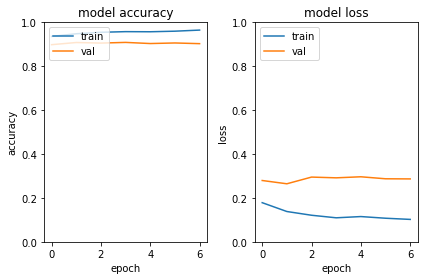

In [68]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

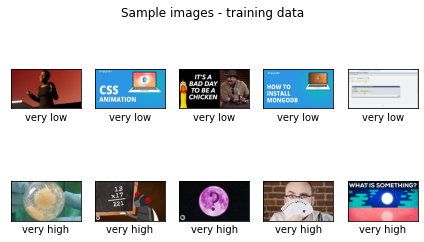

In [27]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - training data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [42]:
# model = load_model(os.path.join(p_dir, "{}".format(m_name)))
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training dataset (in_sample)

In [43]:
img_dir = "../images_medium"

x_train = pd.read_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train = pd.read_pickle(os.path.join(p_dir, "y_train.pkl"))
train_gen = test_generator(x_train, y_train, img_dir, cat_lbl)
y_train_prob = model.predict(train_gen, steps=y_train.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

2021-12-14 20:18:58.138824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-14 20:19:02.737274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


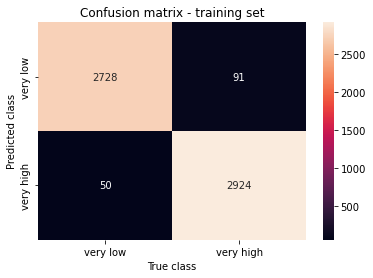

Accuracy: 0.98
Micro precision: 0.98
Micro recall: 0.98
Micro F1-score: 0.98
Macro precision: 0.98
Macro recall: 0.98
Macro F1-score: 0.98
Weighted precision: 0.98
Weighted recall: 0.98
Weighted F1-score: 0.98
              precision    recall  f1-score   support

    very low       0.98      0.97      0.97      2819
   very high       0.97      0.98      0.98      2974

    accuracy                           0.98      5793
   macro avg       0.98      0.98      0.98      5793
weighted avg       0.98      0.98      0.98      5793



In [26]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_val.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

print(classification_report(y_train, y_pred, target_names=cat_lbl))

## Test dataset (out-of_sample)

In [44]:
img_dir = "../images_medium"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir, cat_lbl)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [28]:
print("F1 score: {:0.2f}".format(f1_score(y_test, y_pred, pos_label="very high")))

F1 score: 0.90


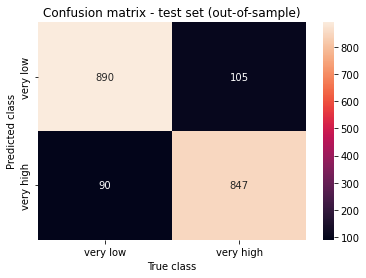

Accuracy: 0.90
Micro precision: 0.90
Micro recall: 0.90
Micro F1-score: 0.90
Macro precision: 0.90
Macro recall: 0.90
Macro F1-score: 0.90
Weighted precision: 0.90
Weighted recall: 0.90
Weighted F1-score: 0.90
              precision    recall  f1-score   support

    very low       0.91      0.89      0.90       995
   very high       0.89      0.90      0.90       937

    accuracy                           0.90      1932
   macro avg       0.90      0.90      0.90      1932
weighted avg       0.90      0.90      0.90      1932



In [29]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

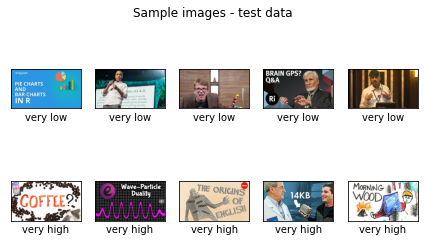

In [30]:
s = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=118))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - test data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images_val.jpg"))

# ROC Curve

In [31]:
class mybinarizer:
    
    def transform(self, s: pd.Series, cats: list) -> np.ndarray:
        d = list()
        for i, v in enumerate(s):
            d.append([l == v for l in cats])
        return np.array(d, dtype="int32")
    
    def reverse_transform(self, arr: np.ndarray) -> pd.Series:
        d = list()
        for i, v in enumerate(arr):
            ct = 0
            for j in v:
                if j == 1:
                    d.append(cat_lbl[ct])
                    continue
                ct += 1
        return pd.Series(d, name="qtl")

## Training dataset (in sample)

In [32]:
lb = mybinarizer()
y_train_no = lb.transform(y_train, cat_lbl)[:, 1]
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

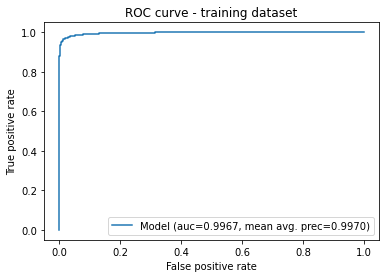

In [33]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test dataset (out-of-sample)

In [41]:
lb = mybinarizer()
y_test_no = lb.transform(y_test, cat_lbl)[:, 1]
y_pred_no = y_pred_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

NameError: name 'mybinarizer' is not defined

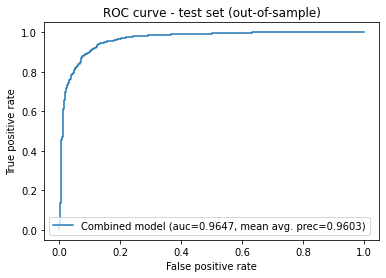

In [35]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

# plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Combined model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr})
df_roc.to_pickle("../roc_combo.pkl")
d_roc = pd.DataFrame({"auc": [auc_model], "mavgp": [mavgp]})
d_roc.to_pickle("../d_combo.pkl")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

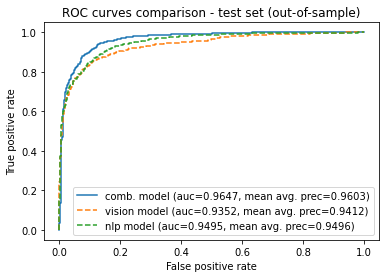

In [36]:
df_combo = pd.read_pickle("../roc_combo.pkl")
d_combo = pd.read_pickle("../d_combo.pkl")
plt.plot(df_combo["fpr"], df_combo["tpr"], label="comb. model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_combo["auc"][0], d_combo["mavgp"][0]))
df_img = pd.read_pickle("../roc_img.pkl")
d_img = pd.read_pickle("../d_img.pkl")
plt.plot(df_img["fpr"], df_img["tpr"], label="vision model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_img["auc"][0], d_img["mavgp"][0]), linestyle="dashed")
df_nlp = pd.read_pickle("../roc_nlp.pkl")
d_nlp = pd.read_pickle("../d_nlp.pkl")
plt.plot(df_nlp["fpr"], df_nlp["tpr"], label="nlp model (auc={:0.4f}, mean avg. prec={:0.4f})".format(d_nlp["auc"][0], d_nlp["mavgp"][0]), linestyle="dashed")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves comparison - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_all.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

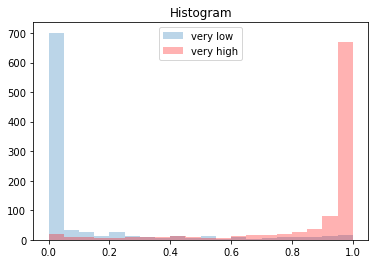

In [37]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl, loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [38]:
cat_lbl2 = ["very low", "low", "high", "very high"]
combo2 = combo.copy()
combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [39]:
combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2896 966 966


In [40]:
test_gen2 = test_generator(x_test2, y_test2, img_dir, cat_lbl)
y_pred_prob2 = model.predict(test_gen2, steps=y_test2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
y_pred2 = pd.Series([cat_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)

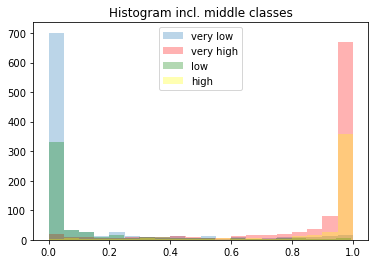

In [41]:
m0 = y_test_no == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no == 1
c1 = y_pred_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

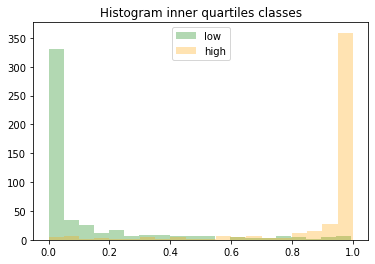

In [42]:
m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 1]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 1]

plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="orange", alpha=0.3, label="", bins=20)
plt.title("Histogram inner quartiles classes")
plt.legend(["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_medium.jpg"))
plt.show()

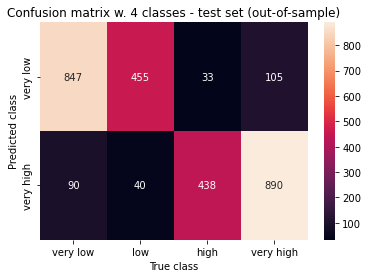

In [43]:
vhvl = pd.concat([y_pred.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1, ignore_index=True)
vhvl.columns = ["pred", "truth"]

hl = pd.concat([y_pred2.reset_index(drop=True), y_test2.reset_index(drop=True)], axis=1, ignore_index=True)
hl.columns = ["pred", "truth"]

tot = pd.concat([vhvl, hl], axis=0)
tot = tot.groupby(["pred", "truth"]).agg({"pred": "count"})
tot.rename(columns={"pred": "count"}, inplace=True)
tot.reset_index(inplace=True)
tot = tot.pivot(index="pred", columns="truth", values="count")
tot = tot.reindex(["very low", "low", "high", "very high"], axis=1)

sb.heatmap(tot, annot=True, fmt="d")
plt.ylabel("Predicted class")
plt.xlabel("True class")
plt.title("Confusion matrix w. 4 classes - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix_4 classes.jpg"))
plt.show()

# Sample images with titles

In [44]:
combo.loc[combo["channel_name"] == "CGP Grey", :].sort_values("ln_vc_norm", ascending=False).head(15)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3249,iHzzSao6ypE,The Simple Solution to Traffic,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-08-31 12:36:39+00:00,682773.0,20459.0,26495364.0,64,30,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.659564,very high
3338,rNu8XDBSn10,"The Difference between the United Kingdom, Gre...",UC2C_jShtL725hvbm1arSV9w,CGP Grey,2011-01-30 16:19:41+00:00,275190.0,10881.0,19081762.0,131,78,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.331327,very high
3291,kF8I_r9XT7A,How to Become Pope,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-02-19 13:30:39+00:00,260288.0,4803.0,15337439.0,106,18,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.112891,very high
3220,oAHbLRjF0vo,The Better Boarding Method Airlines Won't Use,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2019-02-04 18:31:38+00:00,418999.0,8819.0,14510184.0,34,45,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057445,very high
3248,rStL7niR7gs,The Rules for Rulers,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2016-10-24 15:15:59+00:00,419256.0,7164.0,14508362.0,62,20,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.057319,very high
3273,7Pq-S557XQU,Humans Need Not Apply,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-08-13 12:00:03+00:00,316083.0,6458.0,14370579.0,88,21,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,1.047777,very high
3259,jNgP6d9HraI,Brief History of the Royal Family,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2015-09-09 07:10:21+00:00,219467.0,4661.0,13522905.0,75,33,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.986979,very high
3287,qMkYlIA7mgw,Canada & The United States (Bizarre Borders Pa...,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2013-06-05 21:35:43+00:00,149246.0,2041.0,13320196.0,102,51,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.971875,very high
3280,uqH_Y1TupoQ,The Law You Won't Be Told,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-02-12 15:12:25+00:00,206997.0,3735.0,12441879.0,94,25,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.903662,very high
3275,ASSOQDQvVLU,American Empire,UC2C_jShtL725hvbm1arSV9w,CGP Grey,2014-07-03 14:35:38+00:00,150020.0,3437.0,11118117.0,89,15,UC2C_jShtL725hvbm1arSV9w,714557879,2010-08-12 20:12:29+00:00,136,5040000.0,175,0.791170,very high


In [30]:
titles = [
    "These are the asteroids to worry about",
    "The Egg - A Short Story",
    "What is the Wave/Particle Duality? Part 1",
    "How High Can We Build?",
    "Why It Sucks to Be a Male Hyena",
    "The Simple Solution to Traffic"
]
s = combo.loc[combo["title"].isin(titles), ["id_video", "title", "channel_name"]].sort_values(["channel_name"])

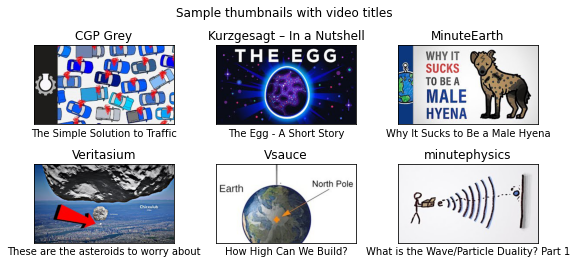

In [35]:
ipr = 3
fig, axs = plt.subplots(len(titles) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    img.save("./Paper images/Img_{}.jpg".format(row["title"].replace("/", " ")))
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout()     
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample images with titles.jpg"))
plt.show()

In [36]:
combo.loc[combo["channel_name"] == "OverSimplified", :].sort_values("ln_vc_norm", ascending=False).head(10)

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl
3158,_uk_6vfqwTA,WW2 - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:13+00:00,674812.0,29126.0,59598408.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,2.421811,very high
3152,I79TpDe3t2g,The Cold War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:43:10+00:00,540455.0,14842.0,38745436.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.991195,very high
3157,fo2Rb9h788s,WW2 - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-03-15 18:52:41+00:00,512250.0,12171.0,37955519.0,45,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.970597,very high
3155,gzALIXcY4pg,The American Revolution - OverSimplified (Par...,UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2018-08-30 18:00:33+00:00,416204.0,12385.0,35028220.0,40,50,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.890336,very high
3164,dHSQAEam2yc,WW1 - Oversimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:18+00:00,384816.0,7014.0,32078562.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.802370,very high
3146,tsxmyL7TUJg,The American Civil War - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2020-01-31 23:00:10+00:00,468609.0,13407.0,30519439.0,23,48,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.752546,very high
3162,ATlila3e9dM,Hitler - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2017-04-18 15:52:33+00:00,379815.0,9398.0,26662380.0,56,32,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.617435,very high
3151,OIYy32RuHao,The Cold War - OverSimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-01-24 22:45:32+00:00,422374.0,8076.0,25677442.0,35,38,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.579795,very high
3149,8qRZcXIODNU,The French Revolution - OverSimplified (Part 1),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2019-06-28 23:41:05+00:00,395085.0,8633.0,24287928.0,30,47,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.524161,very high
3163,Mun1dKkc_As,WW1 - Oversimplified (Part 2),UCNIuvl7V8zACPpTmmNIqP2A,OverSimplified,2016-10-21 11:44:32+00:00,305395.0,7555.0,24159099.0,62,29,UCNIuvl7V8zACPpTmmNIqP2A,614568368,2006-10-28 11:29:15+00:00,182,5290000.0,26,1.518843,very high


In [37]:
titles1 = [
    "Simulating Natural Selection",
    "Mutations and the First Replicators",
    "Exponential growth and epidemics",
    "But how does bitcoin actually work?",
    "WW2 - OverSimplified (Part 1)",
    "WW1 - Oversimplified (Part 1)"
]
s1 = combo.loc[combo["title"].isin(titles1), ["id_video", "title", "channel_name"]].sort_values(["channel_name", "title"])

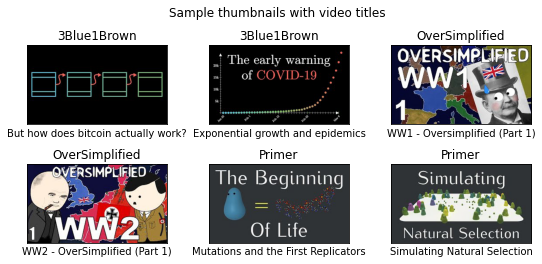

In [38]:
ipr = 3
fig, axs = plt.subplots(len(titles1) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s1.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    img.save("./Paper images/Img_{}.jpg".format(row["title"].replace("/", " ")))
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample thumbnails with video titles", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Channel sample images with titles.jpg"))
plt.show()

In [45]:
res = pd.concat([x_test.reset_index(), y_test.reset_index(), y_pred.reset_index()], axis=1)
res.drop(columns=["index"], inplace=True)
res.rename(columns={0: "pred"}, inplace=True)
res["qtl"] = res["qtl"].astype(object)
res.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
0,1fyS5wqaAS8,"""Hey Bill Nye, Don't Forget the Dioxins!""",UCqoAEDirJPjEUFcF2FklnBA,StarTalk,2016-08-04 01:00:01+00:00,828.0,22.0,22776.0,64,41,UCqoAEDirJPjEUFcF2FklnBA,115816413,2010-12-22 22:12:53+00:00,132,1560000.0,631,-4.226734,very low,very low
1,sCMVw2SJLy4,Live Show - Periodic Table of Videos,UCtESv1e7ntJaLJYKIO1FoYw,Periodic Videos,2009-05-04 13:40:52+00:00,316.0,5.0,17249.0,151,36,UCtESv1e7ntJaLJYKIO1FoYw,260499867,2008-06-06 13:25:43+00:00,162,1520000.0,688,-4.478711,very low,very low
2,ZbdMMI6ty0o,Why Are We Morbidly Curious?,UC6nSFpj9HTCZ5t-N3Rm3-HA,Vsauce,2014-10-08 09:56:00+00:00,169614.0,1925.0,7625854.0,86,28,UC6nSFpj9HTCZ5t-N3Rm3-HA,2141610094,2007-07-30 20:43:33+00:00,173,17100000.0,382,-0.807534,very high,very high
3,nbuM0aJjVgE,The Mughal Empire and Historical Reputation: C...,UCX6b17PVsYBQ0ip5gyeme-Q,CrashCourse,2014-11-21 23:52:06+00:00,34687.0,2003.0,2779386.0,85,76,UCX6b17PVsYBQ0ip5gyeme-Q,1546387741,2006-05-20 02:43:42+00:00,187,12700000.0,1334,-1.519372,very high,very high
4,McojvctVsUs,C++ Basics For Beginners | Learn C++ Programmi...,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,2021-06-05 13:30:02+00:00,373.0,5.0,15171.0,6,91,UCsvqVGtbbyHaMoevxPAq9Fg,89178505,2009-10-29 07:21:23+00:00,146,1320000.0,3011,-4.466001,very low,very low


In [48]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] == res["qtl"]), :].sort_values("ln_vc_norm", ascending=False).iloc[60:70,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
162,iE-3awHYsG8,REALLY BIG MACHINES -- FAK #14,UCqmugCqELzhIMNYnsjScXXw,Vsauce2,2012-04-13 04:09:08+00:00,21371.0,1060.0,7521553.0,116,30,UCqmugCqELzhIMNYnsjScXXw,671152937,2010-12-07 16:43:13+00:00,132,4370000.0,393,0.543010,very high,very high
1871,GAPqEAWW9lc,Mind Field - Official Trailer,UC6nSFpj9HTCZ5t-N3Rm3-HA,Vsauce,2017-01-11 17:30:00+00:00,72091.0,7661.0,29379357.0,59,29,UC6nSFpj9HTCZ5t-N3Rm3-HA,2141610094,2007-07-30 20:43:33+00:00,173,17100000.0,382,0.541214,very high,very high
409,eOCKNH0zaho,Why E=mc² is wrong,UCD5B6VoXv41fJ-IW8Wrhz9A,Fermilab,2017-11-28 21:00:39+00:00,30988.0,3058.0,973738.0,49,18,UCD5B6VoXv41fJ-IW8Wrhz9A,51752717,2006-11-24 18:28:17+00:00,181,570000.0,354,0.535506,very high,very high
1686,ZPUYBsI7Pp0,Birds that Hibernate in Lakes?!,UCeiYXex_fwgYDonaTcSIk6w,MinuteEarth,2013-12-16 21:34:23+00:00,69069.0,3883.0,4405477.0,96,31,UCeiYXex_fwgYDonaTcSIk6w,363864862,2011-10-20 02:21:51+00:00,122,2600000.0,266,0.527337,very high,very high
598,7uiv6tKtoKg,What Will We Miss?,UC6nSFpj9HTCZ5t-N3Rm3-HA,Vsauce,2013-07-28 21:22:24+00:00,657466.0,9861.0,27629425.0,101,18,UC6nSFpj9HTCZ5t-N3Rm3-HA,2141610094,2007-07-30 20:43:33+00:00,173,17100000.0,382,0.479803,very high,very high
104,3HRkKznJoZA,The Pi Song (Memorize 100 Digits Of π) | SCIE...,UCC552Sd-3nyi_tk2BudLUzA,AsapSCIENCE,2018-09-27 16:00:01+00:00,423724.0,5562.0,15693662.0,39,55,UCC552Sd-3nyi_tk2BudLUzA,1538029538,2012-05-28 17:33:43+00:00,115,9740000.0,374,0.477016,very high,very high
749,tG9OKz0jsUY,The Secret Weapon That Could Help Save Bees,UCeiYXex_fwgYDonaTcSIk6w,MinuteEarth,2018-10-04 13:30:31+00:00,40059.0,1862.0,4177127.0,38,43,UCeiYXex_fwgYDonaTcSIk6w,363864862,2011-10-20 02:21:51+00:00,122,2600000.0,266,0.474112,very high,very high
121,f7MzFfuNOtY,The Truth about Hydrogen,UCR1IuLEqb6UEA_zQ81kwXfg,Real Engineering,2018-07-27 14:29:48+00:00,90103.0,5963.0,4920074.0,41,24,UCR1IuLEqb6UEA_zQ81kwXfg,276663744,2013-09-12 06:45:57+00:00,99,3130000.0,128,0.452291,very high,very high
1037,zQGOcOUBi6s,The Immune System Explained I – Bacteria Infec...,UCsXVk37bltHxD1rDPwtNM8Q,Kurzgesagt – In a Nutshell,2014-07-01 16:06:05+00:00,399576.0,7670.0,25276476.0,89,50,UCsXVk37bltHxD1rDPwtNM8Q,1566316247,2013-07-09 20:17:20+00:00,101,16100000.0,145,0.451055,very high,very high
1173,o3I0mJ2RfU0,What Happens When You Stop Smoking?,UCC552Sd-3nyi_tk2BudLUzA,AsapSCIENCE,2017-02-02 17:30:00+00:00,218307.0,5004.0,15228981.0,58,35,UCC552Sd-3nyi_tk2BudLUzA,1538029538,2012-05-28 17:33:43+00:00,115,9740000.0,374,0.446959,very high,very high


In [49]:
titles2 = [
    "A LIVING ROCK? -- Mind Blow #69",
    "Does this look white to you?",
    "Football War - MiniWars #2",
    "What Will We Miss?",
    "The True Science of Parallel Universes",
    "Childbirth vs Getting Kicked in the Balls"
]
s2 = res.loc[res["title"].isin(titles2), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name", "title"])

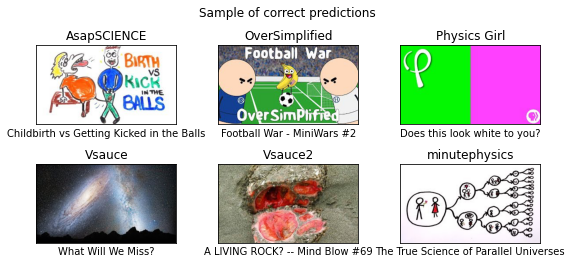

In [50]:
ipr = 3
fig, axs = plt.subplots(len(titles2) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s2.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    img.save("./Paper images/Img_{}.jpg".format(row["title"].replace("/", " ")))
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of correct predictions.jpg"))
plt.show()

In [51]:
# res.loc[(res["pred"] == res["qtl"]) & ("title" == "This is why we can't have nice things"), :].sort_values("ln_vc_norm", ascending=False).iloc[:10,:]
res.loc[(res["pred"] != res["qtl"]), :].sort_values("ln_vc_norm", ascending=True).iloc[80:90,:]

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,id_channel,view_count_channel,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred
997,uYN6gQ4dWZo,#MacroMonday: Angles,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2018-04-23 14:46:44+00:00,290.0,7.0,10599.0,44,20,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,-4.224032,very low,very high
167,eREopphW5Bw,Mining literature for deeper meanings - Amy E....,UCsooa4yRKGN_zEE8iknghZA,TED-Ed,2013-05-31 15:17:07+00:00,2502.0,66.0,220392.0,103,53,UCsooa4yRKGN_zEE8iknghZA,2638922420,2011-03-01 20:33:10+00:00,129,14700000.0,1853,-4.200195,very low,very high
1508,cAD89EjSVVA,Ask Joe Stuff #3,UCH4BNI0-FOK2dMXoFtViWHw,It's Okay To Be Smart,2014-03-31 21:30:01+00:00,1043.0,15.0,60778.0,93,16,UCH4BNI0-FOK2dMXoFtViWHw,359586667,2012-03-17 14:59:36+00:00,117,4000000.0,333,-4.186822,very low,very high
1641,KZWHS5WS210,Your Sleep Questions ANSWERED! LIVE Q&A,UCt_t6FwNsqr3WWoL6dFqG9w,BrainCraft,2020-05-22 23:00:00+00:00,290.0,15.0,8929.0,19,39,UCt_t6FwNsqr3WWoL6dFqG9w,35706035,2013-08-27 06:55:26+00:00,100,584000.0,234,-4.180597,very low,very high
892,_1aj2cqeVIk,Body Parts You’ve Never Heard Of,UCZYTClx2T1of7BRZ86-8fow,SciShow,2021-02-25 22:00:15+00:00,6386.0,58.0,105821.0,10,32,UCZYTClx2T1of7BRZ86-8fow,1427641483,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-4.157029,very low,very high
1377,FnroL1_-l2c,Measuring the migration of river networks,UCFe-pfe0a9bDvWy74Jd7vFg,Massachusetts Institute of Technology (MIT),2014-03-06 19:04:31+00:00,101.0,3.0,11416.0,93,41,UCFe-pfe0a9bDvWy74Jd7vFg,88512314,2009-01-14 16:58:54+00:00,155,724000.0,592,-4.149776,very low,very high
619,nsmQ--a2C_Q,Vacuum Decay: The End Of All Existence? Ft. Ne...,UCqoAEDirJPjEUFcF2FklnBA,StarTalk,2017-07-06 01:14:21+00:00,778.0,34.0,24707.0,53,76,UCqoAEDirJPjEUFcF2FklnBA,115816413,2010-12-22 22:12:53+00:00,132,1560000.0,631,-4.145354,very low,very high
1054,4sMPJOuskUU,Crystal Structure and the Laws of Thermodynamics,UCYeF244yNGuFefuFKqxIAXw,The Royal Institution,2016-12-20 08:51:04+00:00,467.0,8.0,17039.0,60,48,UCYeF244yNGuFefuFKqxIAXw,128175239,2009-09-16 11:05:59+00:00,147,1070000.0,934,-4.139909,very low,very high
1490,bdwU_ZPk1cY,How we can detect pretty much anything - Hélèn...,UCsooa4yRKGN_zEE8iknghZA,TED-Ed,2021-08-24 15:01:02+00:00,8757.0,112.0,235002.0,4,76,UCsooa4yRKGN_zEE8iknghZA,2638922420,2011-03-01 20:33:10+00:00,129,14700000.0,1853,-4.136009,very low,very high
10,5rzhcEnz_3I,Will All Food Eventually Be GMO? with Bill Nye,UCqoAEDirJPjEUFcF2FklnBA,StarTalk,2016-07-14 01:00:00+00:00,961.0,40.0,24987.0,65,46,UCqoAEDirJPjEUFcF2FklnBA,115816413,2010-12-22 22:12:53+00:00,132,1560000.0,631,-4.134085,very low,very high


In [52]:
titles3 = [
    "Derek Muller - The Element of Truth",
    "Cracking the Puzzle of Biodiversity",
    "StarTalk Snippet: Google Says What?",
    "Ask Joe Stuff #3",
    "Announcing the Crash Course Coins",
    "David Moore: Tabletop Physics"
]
s3 = res.loc[res["title"].isin(titles3), ["id_video", "title", "channel_name", "ln_vc_norm"]].sort_values(["channel_name"])

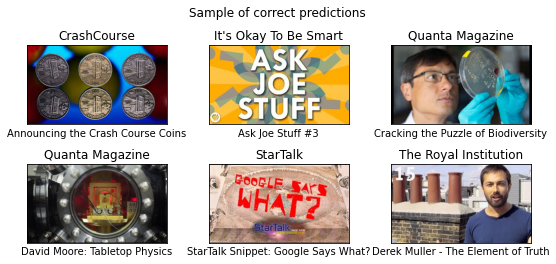

In [53]:
ipr = 3
fig, axs = plt.subplots(len(titles3) // ipr, ipr, figsize=(8, 4))
i = 0
for idx, row in s3.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    img.save("./Paper images/Img_{}.jpg".format(row["title"].replace("/", " ")))
    axs[i // ipr, i % ipr].imshow(img)
    axs[i // ipr, i % ipr].xaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].xaxis.set_ticks([])
    axs[i // ipr, i % ipr].set_xlabel(row["title"])
    axs[i // ipr, i % ipr].set_title(row["channel_name"])
    axs[i // ipr, i % ipr].yaxis.set_ticklabels([])
    axs[i // ipr, i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Sample of correct predictions", x=0.56)
# plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=1.0, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Sample of incorrect predictions.jpg"))
plt.show()

In [62]:
titles4 = [
    "Does this look white to you?",
    "Announcing the Crash Course Coins"
]
s4 = res.loc[res["title"].isin(titles4), ["id_video", "title", "channel_name", "ln_vc_norm", "view_count_video", "subscriber_count"]].sort_values(["channel_name", "title"])

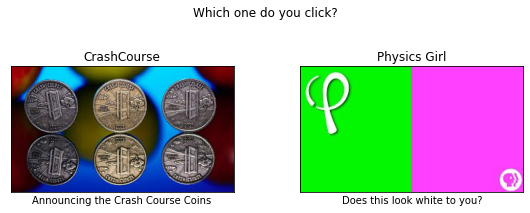

In [63]:
ipr = 2
fig, axs = plt.subplots(len(titles4) // ipr, ipr, figsize=(8, 4))
i = 0

# img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"][0]))
# img = load_img(img_path)
# axs[0, 0].imshow()

for idx, row in s4.iterrows():
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img = load_img(img_path)
    img.save("./Paper images/Img_{}.jpg".format(row["title"].replace("/", " ")))
    axs[i % ipr].imshow(img)
    axs[i % ipr].xaxis.set_ticklabels([])
    axs[i % ipr].xaxis.set_ticks([])
    axs[i % ipr].set_xlabel(row["title"])
    axs[i % ipr].set_title(row["channel_name"])
    axs[i % ipr].yaxis.set_ticklabels([])
    axs[i % ipr].yaxis.set_ticks([])
    # if i % 2 == 0:
    #     axs[i // 2, i % 2].set_ylabel(row["channel_name"])
    i += 1
plt.suptitle("Which one do you click?", x=0.5, y=0.85)
plt.tight_layout(pad=3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.savefig(os.path.join(p_dir, "Which one do you click.jpg"))
plt.show()

In [64]:
s4["exp"] = np.exp(s4["ln_vc_norm"])
s4.head()

,id_video,title,channel_name,ln_vc_norm,view_count_video,subscriber_count,exp
146,Uw42xyb5wz8,Announcing the Crash Course Coins,CrashCourse,-5.278391,64778.0,12700000.0,0.005101
1571,uNOKWoDtbSk,Does this look white to you?,Physics Girl,1.430654,8571941.0,2050000.0,4.181435


# Stuff for Helmut

In [63]:
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9656 entries, 1 to 19310
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id_video            9656 non-null   object             
 1   title               9656 non-null   object             
 2   channel_id          9656 non-null   object             
 3   channel_name        9656 non-null   object             
 4   published_video     9656 non-null   datetime64[ns, UTC]
 5   like_count          9656 non-null   float64            
 6   dislike_count       9656 non-null   float64            
 7   view_count_video    9656 non-null   float64            
 8   published_mth       9656 non-null   int64              
 9   title_len           9656 non-null   int64              
 10  id_channel          9656 non-null   object             
 11  view_count_channel  9656 non-null   int64              
 12  published_channel   9656 non-null

In [64]:
channel = combo.groupby(["channel_name", "qtl"]).agg({"id_video": "count"})

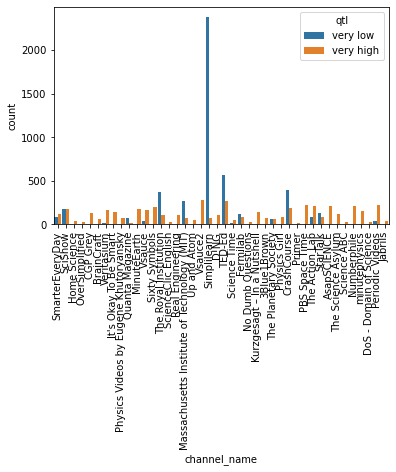

In [96]:
sb.countplot(x="channel_name", hue="qtl", data=combo)
plt.xticks(rotation=90)
plt.savefig(os.path.join(p_dir, "Channel_groundTruth_distribution.jpg"))
plt.show()

In [76]:
img_dir = "../images_medium"

x_train = pd.read_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train = pd.read_pickle(os.path.join(p_dir, "y_train.pkl"))
train_gen = test_generator(x_train, y_train, img_dir, cat_lbl)
y_train_prob = model.predict(train_gen, steps=y_train.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)
train = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)

In [77]:
train.shape

(5793, 19)

In [79]:
x_val = pd.read_pickle(os.path.join(p_dir, "x_val.pkl"))
y_val = pd.read_pickle(os.path.join(p_dir, "y_val.pkl"))
val_gen = test_generator(x_val, y_val, img_dir, cat_lbl)
y_val_prob = model.predict(val_gen, steps=y_val.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)
val = pd.concat([x_val.reset_index(drop=True), y_val.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)

In [81]:
val.shape

(1931, 19)

In [80]:
x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir, cat_lbl)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = pd.Series([cat_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)
test = pd.concat([x_test.reset_index(drop=True), y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)

In [82]:
test.shape

(1932, 19)

In [105]:
tot["ground_truth"] = (tot["qtl"] == "very high").astype(int)
tot["correct_int"] = tot["correct"].astype(int)
# tot.rename(columns={0: "pred"}, inplace=True)
# tot["correct"] = tot["qtl"].astype(str) == tot["pred"].astype(str)

In [106]:
tot.head()

,id_video,title,channel_id,channel_name,published_video,like_count,dislike_count,view_count_video,published_mth,title_len,...,published_channel,age_mth,subscriber_count,video_count,ln_vc_norm,qtl,pred,correct,ground_truth,correct_int
0,tvJ-1rRmGrQ,5 Times Scientists Gave Animals Drugs (and Wha...,UCZYTClx2T1of7BRZ86-8fow,SciShow,2018-11-18 22:00:03+00:00,36768.0,2159.0,1866900.0,37,61,...,2011-10-20 16:11:13+00:00,122,6760000.0,2756,-1.286744,very high,very high,True,1,1
1,vsiPt3l6H3U,"Gold, Sulfur, Vanadium and Cerium (feat. vsauce)",UCtESv1e7ntJaLJYKIO1FoYw,Periodic Videos,2012-07-03 19:24:44+00:00,6643.0,80.0,324401.0,113,48,...,2008-06-06 13:25:43+00:00,162,1520000.0,688,-1.544485,very high,very low,False,1,0
2,C9MdbxPCSYw,Neil deGrasse Tyson Explains the REAL Color of...,UCqoAEDirJPjEUFcF2FklnBA,StarTalk,2021-01-20 00:03:19+00:00,17747.0,303.0,354389.0,11,54,...,2010-12-22 22:12:53+00:00,132,1560000.0,631,-1.482046,very high,very high,True,1,1
3,2OSrvzNW9FE,Backspin Basketball Flies Off Dam,UCHnyfMqiRRG1u-2MsSQLbXA,Veritasium,2015-07-15 15:00:01+00:00,209688.0,3742.0,48860770.0,77,33,...,2010-07-21 07:18:02+00:00,137,10000000.0,320,1.586390,very high,very high,True,1,1
4,dNBKlghgilc,Excel Sorting And Filtering | How To Sort Data...,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,2021-01-08 06:30:04+00:00,65.0,0.0,1757.0,11,100,...,2009-10-29 07:21:23+00:00,146,1320000.0,3011,-6.621779,very low,very low,True,0,1


[]

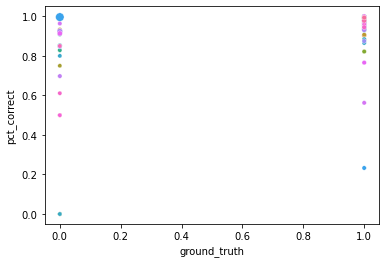

In [125]:
g = tot.groupby(["channel_name", "ground_truth"]).agg({"id_video": "count", "correct_int": "sum"})
g.rename(columns={"id_video": "video_count", "correct_int": "correct"}, inplace=True)
g["pct_correct"] = g["correct"] / g["video_count"]
sb.scatterplot(x="ground_truth", y="pct_correct", hue="channel_name", size="video_count", data=g)
l = plt.legend()
l.remove()
plt.savefig(os.path.join(p_dir, "Channel_groundTruth_pct_correct.jpg"))
plt.plot()

In [122]:
g_det = g.reset_index()
g_det = g_det.loc[g_det["pct_correct"] <= 0.5, ["ground_truth", "channel_name", "pct_correct", "video_count"]]
g_det

,ground_truth,channel_name,pct_correct,video_count
1,0,AsapSCIENCE,0.500000,2
3,0,BrainCraft,0.000000,1
24,0,Numberphile,0.000000,1
39,0,Science ABC,0.000000,1
45,1,Simplilearn,0.232877,73
60,0,Up and Atom,0.500000,2
